<div style="padding:5px;">
    <p style="font-size:42px;"> IBM Data Science : The Battle of Neighborhoods </p>
    <br/>
    <p style="font-size:24px;color: orange;"> City of Baltimore </p>
    <img src="Baltimor1.jpg">
</div>

# 1.1 Importing Libraries.

In [165]:
import warnings                             # to ignore warnings
warnings.filterwarnings('ignore')
import time
import requests                             # library to handle requests
import json                                 # library to handle JSON file
import folium                               # map rendering library
import numpy as np                          # numeric library
import pandas as pd                         # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize   # tranform JSON file into a pandas datafram
import matplotlib.pyplot as mpp
import seaborn as sb
from bs4 import BeautifulSoup               # for scraping web pages
from geopy.geocoders import Nominatim       # convert an address into latitude and longitude values
from sklearn.cluster import KMeans          # clustering model

# 1.2 Reading Data from JSON file.

In [166]:
with open('Population_by_Neighborhood.geojson', 'r') as Nhoods_file:
    Nhoods_data = json.load(Nhoods_file)

In [167]:
Baltimor_Coords = pd.DataFrame()
Baltimor_Dmgphs = pd.DataFrame()

# 1.3 Extracting Neighborhoods informations from Data.

In [168]:
features = Nhoods_data['features']
Baltimor_df = json_normalize(features)

In [169]:
Baltimor_Dmgphs['Neighborhood'] = Baltimor_df['properties.name']
Baltimor_Dmgphs['Population']   = Baltimor_df['properties.population'].astype('float64')
Baltimor_Dmgphs['Num_Latinos']  = Baltimor_df['properties.hisp_lat'].astype('float64')
Baltimor_Dmgphs['Perc_Latinos'] = (Baltimor_Dmgphs['Num_Latinos']/Baltimor_Dmgphs['Population'])*100
Baltimor_Dmgphs['Num_Asian']    = Baltimor_df['properties.asian'].astype('float64')
Baltimor_Dmgphs['Perc_Asian']   = (Baltimor_Dmgphs['Num_Asian']/Baltimor_Dmgphs['Population'])*100
Baltimor_Dmgphs['Num_Black']    = Baltimor_df['properties.blk_afam'].astype('float64')
Baltimor_Dmgphs['Perc_Black']   = (Baltimor_Dmgphs['Num_Black']/Baltimor_Dmgphs['Population'])*100
Baltimor_Dmgphs['Num_White']    = Baltimor_df['properties.white'].astype('float64')
Baltimor_Dmgphs['Perc_White']   = (Baltimor_Dmgphs['Num_White']/Baltimor_Dmgphs['Population'])*100
Baltimor_Dmgphs.set_index('Neighborhood', drop=True, inplace=True)

In [170]:
Baltimor_Dmgphs.shape

(278, 9)

# 1.4 Getting coordinates of the Baltimore.

In [171]:
Geo = Nominatim(user_agent='trk_syr')
Baltimor_Loc = Geo.geocode('Baltimor, MD')
Baltimor_Lat = Baltimor_Loc.latitude
Baltimor_Lng = Baltimor_Loc.longitude
print(f'{Baltimor_Loc} Coordinates  :   {Baltimor_Lat}, {Baltimor_Lng}')

Baltimore, Maryland, 21203, United States of America Coordinates  :   39.2908816, -76.610759


# 1.5 Getting coordinates for each neighborhood in Baltimore, then creating a data frame that includes the name of the neighborhood and its coordinates.

In [172]:
# I wrote the code below this way because of an error I was experiencing due to the slow internet. 
# This is the error: <GeocoderTimedOut: Service timed out>

print('Running...')
None_Nhoods = []
Neihoods = Baltimor_df['properties.name']
start_time = time.time()
for Nhood in Neihoods:
    isError = True
    while isError:
        try:
            Nhood_Loc = Geo.geocode(f'{Nhood}, Baltimore, MD')
            isError   = False
        except: pass
    if Nhood_Loc == None:
        None_Nhoods.append(Nhood)
        continue
    Nhood_Lat       = Nhood_Loc.latitude
    Nhood_Lng       = Nhood_Loc.longitude
    Baltimor_Coords = Baltimor_Coords.append({
                'Neighborhood' : Nhood,
                'Latitude'     : Nhood_Lat,
                'Longitude'    : Nhood_Lng}, ignore_index=True)

end_time = time.time()
print('Time for completed is : ', end_time - start_time)

Running...
Time for completed is :  357.18165397644043


In [173]:
Baltimor_Coords.shape

(227, 3)

### Calculate the number of neighborhoods without coordinates.

In [174]:
num_missing_coords = Baltimor_Dmgphs.shape[0] - Baltimor_Coords.shape[0]
print('The number of neighborhoods without coordinates are : ', num_missing_coords)

The number of neighborhoods without coordinates are :  51


### Will Find the coordinates of neighborhoods in another way.

In [175]:
all_nhoods        = Baltimor_Coords['Neighborhood'].values
copy_of_Baltimore = Baltimor_df.copy()
copy_of_Baltimore.set_index('properties.name', inplace=True)

In [176]:
Nhoods_Geometry = copy_of_Baltimore.loc[None_Nhoods, 'geometry.coordinates']

### We'll take the average of the boundary coordinates for each neighborhood as the point for the neighborhood coordinates.

In [177]:
pred_lats         = []
pred_lngs         = []
pred_coords_lists = []
for Nho in Nhoods_Geometry.keys():
    y_lats   = []
    y_lngs   = []
    y_coords = Nhoods_Geometry[Nho][0][0]
    for y_coord in y_coords:
        y_lngs.append(y_coord[0])
        y_lats.append(y_coord[1])
    pred_coords_lists.append([y_lats, y_lngs])
    y_lat = round(sum(y_lats)/len(y_lats), 6)
    y_lng = round(sum(y_lngs)/len(y_lngs), 6)
    pred_lats.append(y_lat)
    pred_lngs.append(y_lng)

### Testing the Algorithm

In [178]:
x = pred_coords_lists[5][0]
y = pred_coords_lists[5][1]
x1 = pred_lats[5]
y1 = pred_lngs[5]
mpp.plot(x, y)
mpp.plot(x1, y1, 'ro')
mpp.show()

#### Click here.
<!-- 
mpp.figure(figsize=(16, 30))
for ndx in range(1, 52):
    mpp.subplot(11, 5, ndx)
    xlats = pred_coords_lists[num][0]
    ylngs = pred_coords_lists[num][1]
    hx    = pred_lats[num]
    hy    = pred_lngs[num]
    num   += 1
    mpp.plot(xlats, ylngs)
    mpp.plot(hx, hy, 'ro') 
-->

### Create data frame Full_Baltimore_Coords 

In [213]:
Additiona_Coords = pd.DataFrame()
for add_hood, add_lat, add_lng in zip(None_Nhoods, pred_lats, pred_lngs):
    Additiona_Coords = Additiona_Coords.append({
                    'Neighborhood' : add_hood,
                    'Latitude'     : add_lat,
                    'Longitude'    : add_lng}, ignore_index=True)

In [221]:
Full_Baltimor_Coords = pd.concat([Baltimor_Coords, Additiona_Coords], ignore_index=True)
Full_Baltimor_Coords.set_index('Neighborhood', drop=True, inplace=True)
Full_Baltimor_Coords.shape

(278, 2)

In [223]:
Full_Baltimor_Coords.sort_index(inplace=True)
Baltimor_Dmgphs.sort_index(inplace=True)

# 1.6 Showing neighborhoods on the map using folium library.

In [225]:
Baltimor_Map = folium.Map(location=[Baltimor_Lat, Baltimor_Lng], zoom_start=10)

for latitude, longitude, neighborhood in zip(Baltimor_Coords['Latitude'], 
                                             Baltimor_Coords['Longitude'], 
                                             Baltimor_Coords.index):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#efef7f',
        fill_opacity=0.9,
        parse_html=False).add_to(Baltimor_Map)  
Baltimor_Map

# 1.7 Creating Foursquare API url and getting venues in city of Baltimore.

In [226]:
CLIENT_ID     = '312RPHAVLSOXOZVK4X1YU4IYTWRNLQVEN04RXXMYIK4DZGXU'
CLIENT_SECRET = 'WE3FFX55NZ3OCXFLOL3GZ3RAUH5PGDYEXEQOYMLLOMKQ3MDX'
VERSION       = '20191005'     # Foursquare API version
n_lat         = Baltimor_Lat   # neighborhood latitude
n_lng         = Baltimor_Lng   # neighborhood longtude
LIMIT         = 100            # limit of number of venues returned by Foursquare API
radius        = 500            # define radius
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={n_lat},{n_lng}&radius={radius}&limit={LIMIT}'
url

'https://api.foursquare.com/v2/venues/explore?&client_id=312RPHAVLSOXOZVK4X1YU4IYTWRNLQVEN04RXXMYIK4DZGXU&client_secret=WE3FFX55NZ3OCXFLOL3GZ3RAUH5PGDYEXEQOYMLLOMKQ3MDX&v=20191005&ll=39.2908816,-76.610759&radius=500&limit=100'

In [227]:
results = requests.get(url).json()
venues  = results['response']['groups'][0]['items']

# 1.8 Converting JSON file to data frame, then selecting specific features to show in dataframe.

In [228]:
nearby_venues = json_normalize(venues)
selected_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, selected_columns]
nearby_venues['venue.categories'] = [category[0]['name'] for category in nearby_venues['venue.categories']]
nearby_venues.columns = ['Name', 'Category', 'Latitude', 'Longitude']

# 1.9 ٍShowing venues on map.

In [229]:
Baltimor_Map2 = folium.Map(location=[Baltimor_Lat, Baltimor_Lng], zoom_start=15)

for latitude, longitude, neighborhood in zip(nearby_venues['Latitude'], nearby_venues['Longitude'], nearby_venues['Name']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#efef7f',
        fill_opacity=0.9,
        parse_html=False).add_to(Baltimor_Map2)  
Baltimor_Map2

# 2.0 Creating a function to get places, depending on the coordinates of each neighborhood, then running it.

In [230]:
def GetVenues(Neighborhoods, Latitudes, Longitudes, Radius=500):
    List_of_veneus = []
    CLIENT_ID      = '312RPHAVLSOXOZVK4X1YU4IYTWRNLQVEN04RXXMYIK4DZGXU'
    CLIENT_SECRET  = 'WE3FFX55NZ3OCXFLOL3GZ3RAUH5PGDYEXEQOYMLLOMKQ3MDX'
    VERSION        = '20191005'
    LIMIT          = 100
    for Nhood, N_lat, N_lng in zip(Neighborhoods, Latitudes, Longitudes):
        n_url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={N_lat},{N_lng}&radius={Radius}&limit={LIMIT}'
        Results = requests.get(n_url).json()['response']['groups'][0]['items']
        List_of_veneus.append([[
            Nhood, 
            N_lat, 
            N_lng, 
            Venue['venue']['name'], 
            Venue['venue']['location']['lat'], 
            Venue['venue']['location']['lng'],  
            Venue['venue']['categories'][0]['name']] for Venue in Results])

    venues = pd.DataFrame([n_feature for venue in List_of_veneus for n_feature in venue])
    venues.columns = ['Neighborhood', 
                      'Neighborhood_Latitude', 
                      'Neighborhood_Longitude', 
                      'Venue', 
                      'Venue_Latitude', 
                      'Venue_Longitude', 
                      'Venue_Category']
    
    return venues

In [231]:
st = time.time()
Venues_in_Baltimor = GetVenues(Neighborhoods = Full_Baltimor_Coords.index, 
                               Latitudes     = Full_Baltimor_Coords['Latitude'], 
                               Longitudes    = Full_Baltimor_Coords['Longitude'])
print('Time left is :  ', time.time() - st)

Time left is :   1077.7476019859314


# 2.1 Shownig venues in all neighborhoods on the map.

In [232]:
Baltimor_Map3 = folium.Map(location=[Baltimor_Lat, Baltimor_Lng], zoom_start=15)

for latitude, longitude, category in zip(Venues_in_Baltimor['Venue_Latitude'], 
                                        Venues_in_Baltimor['Venue_Longitude'], 
                                        Venues_in_Baltimor['Venue_Category']):
    label = folium.Popup(category, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#efef7f',
        fill_opacity=0.9,
        parse_html=False).add_to(Baltimor_Map3)
Baltimor_Map3

# 3.0 Clustering

## Preparing data frame to Clustering.

In [354]:
Num_Mexican_Restaurant = pd.get_dummies(Venues_in_Baltimor['Venue_Category'], prefix='', prefix_sep='')
Num_Mexican_Restaurant.set_index(Venues_in_Baltimor['Neighborhood'], inplace=True)
Num_Mexican_Restaurant = Num_Mexican_Restaurant['Mexican Restaurant'].groupby('Neighborhood').sum()
Num_Mexican_Restaurant.value_counts()

0    243
1     17
2      6
3      4
4      1
Name: Mexican Restaurant, dtype: int64

In [355]:
New_Baltimor_Gmgphs = Baltimor_Dmgphs.loc[Num_Mexican_Restaurant.index, :]
New_Baltimor_Gmgphs['Num_MexRes'] = Num_Mexican_Restaurant
New_Baltimor_Gmgphs.head()

Population  Num_Latinos  Perc_Latinos  Num_Asian  \
Neighborhood                                                          
Abell                   889.0         30.0      3.374578       33.0   
Allendale              3554.0         21.0      0.590884        6.0   
Arcadia                1235.0         31.0      2.510121       12.0   
Arlington              2598.0         17.0      0.654349        9.0   
Armistead Gardens      3458.0        841.0     24.320416       14.0   

                   Perc_Asian  Num_Black  Perc_Black  Num_White  Perc_White  \
Neighborhood                                                                  
Abell                3.712036      213.0   23.959505      606.0   68.166479   
Allendale            0.168824     3497.0   98.396173       18.0    0.506472   
Arcadia              0.971660      537.0   43.481781      623.0   50.445344   
Arlington            0.346420     2496.0   96.073903       33.0    1.270208   
Armistead Gardens    0.404858      108.0    3.123193     2698.0   78.021978   

                   Num_MexRes  
Neighborhood                   
Abell                       1  
Allendale                   0  
Arcadia                     0  
Arlington                   0  
Armistead Gardens           0

In [356]:
New_Baltimor_Gmgphs.dropna(axis=0, inplace=True)

### Correlation Analysis between features.

In [357]:
Corr = New_Baltimor_Gmgphs.corr()
mpp.figure(figsize=(10, 6))
sb.heatmap(Corr, annot=True, fmt='.2f')

### Getting the optimum value for k

In [358]:
squared_distances = []
clusters = range(1, 12)
for k in clusters:
    check_KmeansModel = KMeans(n_clusters=k, random_state=42).fit(New_Baltimor_Gmgphs)
    squared_distances.append(check_KmeansModel.inertia_)

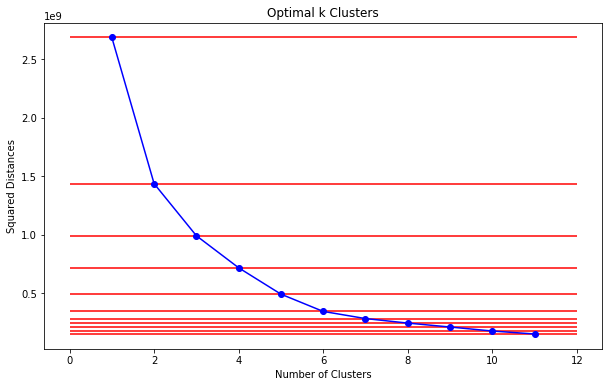

In [359]:
mpp.figure(figsize=(10, 6))
mpp.plot(clusters, squared_distances, 'bo-')
mpp.hlines(squared_distances, 0, 12, 'red')
mpp.xlabel('Number of Clusters')
mpp.ylabel('Squared Distances')
mpp.title('Optimal k Clusters')
mpp.show()

### Fit KMeans Model with n_clusters=6.

In [360]:
KmeansModel = KMeans(n_clusters=6, random_state=42).fit(New_Baltimor_Gmgphs)

### Add clusters labels to dataframe.

In [361]:
Final_DF = New_Baltimor_Gmgphs.copy()
Final_DF['K_Label'] = KmeansModel.labels_

# 3.1 Clusters with ِAnalysis.

## Cluster 1

In [362]:
Cluster_1 = Final_DF[Final_DF['K_Label']==5]
Cluster_1

Population  Num_Latinos  Perc_Latinos  Num_Asian  \
Neighborhood                                                                    
Armistead Gardens                3458.0        841.0     24.320416       14.0   
Baltimore Highlands              2703.0       1117.0     41.324454       75.0   
Bolton Hill                      4974.0        163.0      3.277041      361.0   
Curtis Bay                       4063.0        227.0      5.587005      104.0   
Downtown                         4448.0        234.0      5.260791      927.0   
Fallstaff                        4219.0        589.0     13.960654      102.0   
Federal Hill                     2600.0         79.0      3.038462       86.0   
Fells Point                      3976.0        444.0     11.167002      208.0   
Greektown                        3678.0       1293.0     35.154976       56.0   
Guilford                         2214.0         70.0      3.161698      100.0   
Highlandtown                     2666.0        750.0     28.132033       36.0   
Homeland                         3201.0         80.0      2.499219      116.0   
Lakeland                         4551.0        889.0     19.534168      132.0   
Lauraville                       4151.0        120.0      2.890870       52.0   
Locust Point                     2138.0         37.0      1.730589       53.0   
Loyola/Notre Dame                3208.0        158.0      4.925187      108.0   
Medfield                         2748.0        113.0      4.112082      216.0   
Mid-Town Belvedere               3830.0        178.0      4.647520      329.0   
Morrell Park                     4204.0        217.0      5.161751      132.0   
Mount Vernon                     4818.0        229.0      4.753010      458.0   
Mount Washington                 3878.0        107.0      2.759154       81.0   
North Harford Road               5380.0        251.0      4.665428       50.0   
Patterson Park Neighborhood      5820.0       1624.0     27.903780      143.0   
Remington                        2458.0        113.0      4.597234      213.0   
Riverside                        5671.0        159.0      2.803738      143.0   
Roland Park                      5269.0        170.0      3.226419      465.0   
South Baltimore                  3450.0        138.0      4.000000       69.0   
Tuscany-Canterbury               3413.0        122.0      3.574568      790.0   
Upper Fells Point                3851.0        832.0     21.604778      142.0   
Violetville                      2506.0         72.0      2.873105       42.0   
Washington Village/Pigtown       5116.0        177.0      3.459734      265.0   
Westfield                        3141.0        110.0      3.502069       42.0   

                             Perc_Asian  Num_Black  Perc_Black  Num_White  \
Neighborhood                                                                
Armistead Gardens              0.404858      108.0    3.123193     2698.0   
Baltimore Highlands            2.774695      700.0   25.897151     1023.0   
Bolton Hill                    7.257740     1581.0   31.785283     2807.0   
Curtis Bay                     2.559685     1086.0   26.729018     2512.0   
Downtown                      20.840827     1126.0   25.314748     2161.0   
Fallstaff                      2.417635     2031.0   48.139370     1575.0   
Federal Hill                   3.307692      132.0    5.076923     2315.0   
Fells Point                    5.231388      349.0    8.777666     3074.0   
Greektown                      1.522567      251.0    6.824361     2401.0   
Guilford                       4.516712      221.0    9.981933     1810.0   
Highlandtown                   1.350338      336.0   12.603151     1779.0   
Homeland                       3.623868      232.0    7.247735     2782.0   
Lakeland                       2.900461     2509.0   55.130740     1370.0   
Lauraville                     1.252710     2222.0   53.529270     1698.0   
Locust Point                   2.478952   

In [363]:
Cluster_1.describe()

Population  Num_Latinos  Perc_Latinos   Num_Asian  Perc_Asian  \
count    32.000000    32.000000     32.000000   32.000000   32.000000   
mean   3806.281250   365.718750      9.675279  190.937500    4.919298   
std    1036.012524   406.889954     10.815170  210.960008    5.166666   
min    2138.000000    37.000000      1.730589   14.000000    0.404858   
25%    3042.750000   113.000000      3.210239   65.750000    2.066529   
50%    3840.500000   173.500000      4.622377  112.000000    3.020164   
75%    4473.750000   480.250000     11.865415  213.750000    5.737976   
max    5820.000000  1624.000000     41.324454  927.000000   23.146792   

         Num_Black  Perc_Black    Num_White  Perc_White  Num_MexRes  K_Label  
count    32.000000   32.000000    32.000000   32.000000   32.000000     32.0  
mean    831.500000   20.263245  2476.750000   66.643997    0.468750      5.0  
std     763.525355   16.196161   846.100238   17.963467    1.077164      0.0  
min      27.000000    1.262862  1023.000000   30.103274    0.000000      5.0  
25%     229.250000    6.847612  1966.750000   54.940500    0.000000      5.0  
50%     533.000000   13.271128  2390.500000   68.231277    0.000000      5.0  
75%    1287.000000   27.271849  2857.500000   79.381943    0.000000      5.0  
max    2611.000000   55.130740  5275.000000   94.434051    4.000000      5.0

In [364]:
#PFT = Percentage From Total
PFT1_Population = (Cluster_1['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT1_Latinos    = (Cluster_1['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT1_Black      = (Cluster_1['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT1_White      = (Cluster_1['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT1_MexRest    = (Cluster_1['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100

print('--------------------- Cluster 1 ----------------------')
print('Percentage from Total Population  :   ', PFT1_Population)
print('Percentage from Total Latinos     :   ', PFT1_Latinos)
print('Percentage from Total Black       :   ', PFT1_Black)
print('Percentage from Total White       :   ', PFT1_White)
print('Percentage from Total MexRest     :   ', PFT1_MexRest)

--------------------- Cluster 1 ----------------------
Percentage from Total Population  :    20.360773903653207
Percentage from Total Latinos     :    45.825828177617666
Percentage from Total Black       :    6.920822029688163
Percentage from Total White       :    45.672267939054464
Percentage from Total MexRest     :    37.5


## Cluster 2

In [365]:
Cluster_2 = Final_DF[Final_DF['K_Label']==4]
Cluster_2

Population  Num_Latinos  Perc_Latinos  Num_Asian  Perc_Asian  \
Neighborhood                                                                    
Brooklyn             9996.0       1149.0     11.494598      148.0    1.480592   
Canton              12192.0        641.0      5.257546      383.0    3.141404   
Charles Village      8906.0        491.0      5.513137     1883.0   21.143050   
Hampden              6963.0        221.0      3.173919      186.0    2.671262   

                 Num_Black  Perc_Black  Num_White  Perc_White  Num_MexRes  \
Neighborhood                                                                
Brooklyn            4051.0   40.526210     4788.0   47.899160           0   
Canton               485.0    3.978018    10811.0   88.672900           1   
Charles Village     1313.0   14.742870     5187.0   58.241635           0   
Hampden              314.0    4.509550     6208.0   89.156973           2   

                 K_Label  
Neighborhood              
Brooklyn               4  
Canton                 4  
Charles Village        4  
Hampden                4

In [366]:
Cluster_2.describe()

Population  Num_Latinos  Perc_Latinos    Num_Asian  Perc_Asian  \
count      4.000000     4.000000      4.000000     4.000000    4.000000   
mean    9514.250000   625.500000      6.359800   650.000000    7.109077   
std     2181.839648   389.873056      3.579934   828.427828    9.382055   
min     6963.000000   221.000000      3.173919   148.000000    1.480592   
25%     8420.250000   423.500000      4.736639   176.500000    2.373595   
50%     9451.000000   566.000000      5.385342   284.500000    2.906333   
75%    10545.000000   768.000000      7.008502   758.000000    7.641816   
max    12192.000000  1149.000000     11.494598  1883.000000   21.143050   

         Num_Black  Perc_Black     Num_White  Perc_White  Num_MexRes  K_Label  
count     4.000000    4.000000      4.000000    4.000000    4.000000      4.0  
mean   1540.750000   15.939162   6748.500000   70.992667    0.750000      4.0  
std    1729.426567   17.123659   2773.559025   21.122118    0.957427      0.0  
min     314.000000    3.978018   4788.000000   47.899160    0.000000      4.0  
25%     442.250000    4.376667   5087.250000   55.656016    0.000000      4.0  
50%     899.000000    9.626210   5697.500000   73.457268    0.500000      4.0  
75%    1997.500000   21.188705   7358.750000   88.793918    1.250000      4.0  
max    4051.000000   40.526210  10811.000000   89.156973    2.000000      4.0

In [367]:
PFT2_Population = (Cluster_2['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT2_Latinos    = (Cluster_2['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT2_Black      = (Cluster_2['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT2_White      = (Cluster_2['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT2_MexRest    = (Cluster_2['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100

print('--------------------- Cluster 1 ----------------------')
print('Percentage from Total Population  :   ', PFT2_Population)
print('Percentage from Total Latinos     :   ', PFT2_Latinos)
print('Percentage from Total Black       :   ', PFT2_Black)
print('Percentage from Total White       :   ', PFT2_White)
print('Percentage from Total MexRest     :   ', PFT2_MexRest)

--------------------- Cluster 1 ----------------------
Percentage from Total Population  :    6.361770202636515
Percentage from Total Latinos     :    9.797165009006187
Percentage from Total Black       :    1.6030151145884
Percentage from Total White       :    15.555632390567734
Percentage from Total MexRest     :    7.5


## Cluster 3

In [368]:
Cluster_3 = Final_DF[Final_DF['K_Label']==3]
Cluster_3

Population  Num_Latinos  Perc_Latinos  Num_Asian  Perc_Asian  \
Neighborhood                                                                  
Belair-Edison     16690.0        199.0      1.192331       81.0    0.485321   
Frankford         17694.0        362.0      2.045891      400.0    2.260653   

               Num_Black  Perc_Black  Num_White  Perc_White  Num_MexRes  \
Neighborhood                                                              
Belair-Edison    14958.0   89.622528     1338.0    8.016777           0   
Frankford        14595.0   82.485588     2092.0   11.823217           0   

               K_Label  
Neighborhood            
Belair-Edison        3  
Frankford            3

In [369]:
Cluster_3.describe()

Population  Num_Latinos  Perc_Latinos   Num_Asian  Perc_Asian  \
count      2.000000     2.000000      2.000000    2.000000    2.000000   
mean   17192.000000   280.500000      1.619111  240.500000    1.372987   
std      709.935208   115.258405      0.603558  225.567063    1.255350   
min    16690.000000   199.000000      1.192331   81.000000    0.485321   
25%    16941.000000   239.750000      1.405721  160.750000    0.929154   
50%    17192.000000   280.500000      1.619111  240.500000    1.372987   
75%    17443.000000   321.250000      1.832501  320.250000    1.816820   
max    17694.000000   362.000000      2.045891  400.000000    2.260653   

          Num_Black  Perc_Black    Num_White  Perc_White  Num_MexRes  K_Label  
count      2.000000    2.000000     2.000000    2.000000         2.0      2.0  
mean   14776.500000   86.054058  1715.000000    9.919997         0.0      3.0  
std      256.679762    5.046579   533.158513    2.691560         0.0      0.0  
min    14595.000000   82.485588  1338.000000    8.016777         0.0      3.0  
25%    14685.750000   84.269823  1526.500000    8.968387         0.0      3.0  
50%    14776.500000   86.054058  1715.000000    9.919997         0.0      3.0  
75%    14867.250000   87.838293  1903.500000   10.871607         0.0      3.0  
max    14958.000000   89.622528  2092.000000   11.823217         0.0      3.0

In [370]:
PFT3_Population = (Cluster_3['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT3_Latinos    = (Cluster_3['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT3_Black      = (Cluster_3['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT3_White      = (Cluster_3['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT3_MexRest    = (Cluster_3['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100

print('--------------------- Cluster 1 ----------------------')
print('Percentage from Total Population  :   ', PFT3_Population)
print('Percentage from Total Latinos     :   ', PFT3_Latinos)
print('Percentage from Total Black       :   ', PFT3_Black)
print('Percentage from Total White       :   ', PFT3_White)
print('Percentage from Total MexRest     :   ', PFT3_MexRest)

--------------------- Cluster 1 ----------------------
Percentage from Total Population  :    5.747775879534749
Percentage from Total Latinos     :    2.1967264468634973
Percentage from Total Black       :    7.686825520271132
Percentage from Total White       :    1.976580688288039
Percentage from Total MexRest     :    0.0


## Cluster 4

In [371]:
Cluster_4 = Final_DF[Final_DF['K_Label']==2]
Cluster_4

Population  Num_Latinos  Perc_Latinos  \
Neighborhood                                                             
Allendale                            3554.0         21.0      0.590884   
Arlington                            2598.0         17.0      0.654349   
Ashburton                            2520.0         39.0      1.547619   
Barclay                              2181.0         78.0      3.576341   
Beechfield                           3708.0         87.0      2.346278   
Berea                                3865.0         35.0      0.905563   
Better Waverly                       2874.0         92.0      3.201113   
Bridgeview/Greenlawn                 1975.0         11.0      0.556962   
Callaway-Garrison                    1798.0         11.0      0.611791   
Carrollton Ridge                     3645.0        108.0      2.962963   
Cedmont                              2594.0         66.0      2.544333   
Cedonia                              3316.0         63.0      1.899879   
Coppin Heights/Ash-Co-East           2660.0         20.0      0.751880   
Cylburn                              2357.0         26.0      1.103097   
Dolfield                             2156.0         17.0      0.788497   
East Arlington                       2432.0         27.0      1.110197   
East Baltimore Midway                3034.0         13.0      0.428477   
Edgewood                             2399.0         20.0      0.833681   
Edmondson Village                    3940.0         32.0      0.812183   
Ellwood Park/Monument                3580.0        501.0     13.994413   
Franklin Square                      2967.0        108.0      3.640040   
Franklintown Road                    1940.0         31.0      1.597938   
Gay Street                           1998.0         16.0      0.800801   
Glen Oaks                            2887.0         55.0      1.905092   
Greenspring                          3436.0         17.0      0.494761   
Grove Park                           1934.0         19.0      0.982420   
Hanlon-Longwood                      2311.0         35.0      1.514496   
Harlem Park                          3654.0         29.0      0.793651   
Hillen                               2344.0         24.0      1.023891   
Idlewood                             2676.0         65.0      2.428999   
Irvington                            4167.0         55.0      1.319894   
Johnston Square                      1906.0         20.0      1.049318   
Madison Park                         2134.0         38.0      1.780694   
Madison-Eastend                      2487.0         53.0      2.131082   
McElderry Park                       4033.0        473.0     11.728242   
Midtown-Edmondson                    1663.0          7.0      0.420926   
Mondawmin                            3512.0         51.0      1.452164   
Morgan State University              1790.0          5.0      0.279330   
New Southwest/Mount Clare            2313.0        267.0     11.543450   
Northwest Community Action           1896.0         25.0      1.318565   
Oldtown                              2658.0         11.0      0.413845   
Oliver                               4153.0         39.0      0.939080   
Park Circle                          3153.0         44.0      1.395496   
Parklane                             2049.0         20.0      0.976086   
Parkside                             2683.0         28.0      1.043608   
Parkview/Woodbrook                   1981.0         25.0      1.261989   
Pen Lucy                             3078.0         43.0      1.397011   
Penn North                           1846.0         10.0      0.541712   
Penrose/Fayette Street Outreach      3266.0         22.0      0.673607   
Poppleton                            3105.0         25.0      0.805153   
Ramblewood                           1705.0          9.0      0.527859   
Reisterstown Station                 1968.0        116.0      5.894309   
Rognel Heights                       

In [372]:
Cluster_4.describe()

Population  Num_Latinos  Perc_Latinos  Num_Asian  Perc_Asian  \
count    65.000000    65.000000     65.000000  65.000000   65.000000   
mean   2616.615385    52.815385      1.871159  16.876923    0.630057   
std     700.542863    86.946444      2.538680  19.524430    0.675600   
min    1663.000000     5.000000      0.279330   0.000000    0.000000   
25%    2032.000000    19.000000      0.777732   5.000000    0.196850   
50%    2487.000000    27.000000      1.103097  10.000000    0.370745   
75%    3102.000000    51.000000      1.862302  22.000000    0.782093   
max    4167.000000   501.000000     13.994413  88.000000    3.279911   

         Num_Black  Perc_Black    Num_White  Perc_White  Num_MexRes  K_Label  
count    65.000000   65.000000    65.000000   65.000000   65.000000     65.0  
mean   2367.846154   90.907632   158.000000    5.736519    0.015385      2.0  
std     666.582732   10.389649   248.733102    8.643503    0.124035      0.0  
min    1190.000000   50.385505     5.000000    0.257732    0.000000      2.0  
25%    1882.000000   88.604087    30.000000    1.142514    0.000000      2.0  
50%    2222.000000   95.472441    46.000000    2.061529    0.000000      2.0  
75%    2838.000000   96.468254   176.000000    6.656504    0.000000      2.0  
max    4016.000000   98.396173  1222.000000   45.296839    1.000000      2.0

In [373]:
PFT4_Population = (Cluster_4['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT4_Latinos    = (Cluster_4['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT4_Black      = (Cluster_4['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT4_White      = (Cluster_4['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT4_MexRest    = (Cluster_4['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100

print('----------------------- Cluster 1 ------------------------')
print('Percentage from Total Population  :   ', PFT4_Population)
print('Percentage from Total Latinos     :   ', PFT4_Latinos)
print('Percentage from Total Black       :   ', PFT4_Black)
print('Percentage from Total White       :   ', PFT4_White)
print('Percentage from Total MexRest     :   ', PFT4_MexRest)

----------------------- Cluster 1 ------------------------
Percentage from Total Population  :    28.431297161216555
Percentage from Total Latinos     :    13.442712820111208
Percentage from Total Black       :    40.032460860993126
Percentage from Total White       :    5.918216813037365
Percentage from Total MexRest     :    2.5


## Cluster 5

In [374]:
Cluster_5 = Final_DF[Final_DF['K_Label']==1]
Cluster_5

Population  Num_Latinos  Perc_Latinos  \
Neighborhood                                                             
Broadway East                        4931.0         65.0      1.318191   
Central Park Heights                 6026.0         85.0      1.410554   
Cherry Hill                          8367.0        140.0      1.673240   
Coldstream Homestead Montebello      7266.0        102.0      1.403799   
Ednor Gardens-Lakeside               5185.0         70.0      1.350048   
Glen                                 7876.0        154.0      1.955307   
Glenham-Belhar                       6175.0        124.0      2.008097   
Hamilton Hills                       9752.0        266.0      2.727646   
Howard Park                          5929.0        104.0      1.754090   
Loch Raven                           6163.0        110.0      1.784845   
New Northwood                        4972.0        102.0      2.051488   
Penn-Fallsway                        6423.0        147.0      2.288650   
Reservoir Hill                       6140.0        112.0      1.824104   
Sandtown-Winchester                  8534.0         51.0      0.597610   
Upton                                5746.0         73.0      1.270449   
Waltherson                           6980.0        130.0      1.862464   

                                 Num_Asian  Perc_Asian  Num_Black  Perc_Black  \
Neighborhood                                                                    
Broadway East                         17.0    0.344758     4681.0   94.930034   
Central Park Heights                  15.0    0.248921     5774.0   95.818121   
Cherry Hill                           21.0    0.250986     7919.0   94.645632   
Coldstream Homestead Montebello       31.0    0.426645     6972.0   95.953757   
Ednor Gardens-Lakeside                93.0    1.793635     4153.0   80.096432   
Glen                                  72.0    0.914170     4624.0   58.710005   
Glenham-Belhar                        59.0    0.955466     3573.0   57.862348   
Hamilton Hills                        94.0    0.963905     6837.0   70.108696   
Howard Park                           19.0    0.320459     5588.0   94.248609   
Loch Raven                           120.0    1.947104     5422.0   87.976635   
New Northwood                         30.0    0.603379     4677.0   94.066774   
Penn-Fallsway                          9.0    0.140121     5374.0   83.668068   
Reservoir Hill                        22.0    0.358306     5415.0   88.192182   
Sandtown-Winchester                   20.0    0.234357     8304.0   97.304898   
Upton                                  8.0    0.139227     5546.0   96.519318   
Waltherson                            78.0    1.117479     4683.0   67.091691   

                                 Num_White  Perc_White  Num_MexRes  K_Label  
Neighborhood                                                                 
Broadway East                        117.0    2.372744           0        1  
Central Park Heights                 109.0    1.808828           0        1  
Cherry Hill                          238.0    2.844508           0        1  
Coldstream Homestead Montebello      118.0    1.624002           0        1  
Ednor Gardens-Lakeside               802.0   15.467695           0        1  
Glen                                2949.0   37.442864           0        1  
Glenham-Belhar                      2314.0   37.473684           0        1  
Hamilton Hills                      2495.0   25.584495           0        1  
Howard Park                          174.0    2.934728           0        1  
Loch Raven                           505.0    8.194061           0        1  
New Northwood                        134.0    2.695093           0        1  
Penn-Fallsway                        967.0   15.055270           0        1  
Reservoir Hill                       522.0    8.501629           0        1  
Sandtown-Winchester                   95.0    1.113194           0     

In [375]:
Cluster_5.describe()

Population  Num_Latinos  Perc_Latinos   Num_Asian  Perc_Asian  \
count    16.000000    16.000000     16.000000   16.000000   16.000000   
mean   6654.062500   114.687500      1.705036   44.250000    0.672432   
std    1379.102194    50.367607      0.488398   36.065681    0.566575   
min    4931.000000    51.000000      0.597610    8.000000    0.139227   
25%    5883.250000    82.000000      1.390361   18.500000    0.250470   
50%    6169.000000   107.000000      1.769468   26.000000    0.392475   
75%    7418.500000   132.500000      1.968505   73.500000    0.957575   
max    9752.000000   266.000000      2.727646  120.000000    1.947104   

         Num_Black  Perc_Black    Num_White  Perc_White  Num_MexRes  K_Label  
count    16.000000   16.000000    16.000000   16.000000        16.0     16.0  
mean   5596.375000   84.824575   849.937500   12.054105         0.0      1.0  
std    1315.156106   13.892348   997.046536   13.130645         0.0      0.0  
min    3573.000000   57.862348    78.000000    1.113194         0.0      1.0  
25%    4680.000000   77.599498   117.750000    2.231765         0.0      1.0  
50%    5418.500000   91.129478   371.500000    5.564394         0.0      1.0  
75%    6039.750000   95.152056  1220.750000   17.996895         0.0      1.0  
max    8304.000000   97.304898  2949.000000   37.473684         0.0      1.0

In [376]:
PFT5_Population = (Cluster_5['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT5_Latinos    = (Cluster_5['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT5_Black      = (Cluster_5['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT5_White      = (Cluster_5['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT5_MexRest    = (Cluster_5['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100
  
print('----------------------- Cluster 1 ------------------------')
print('Percentage from Total Population  :   ', PFT5_Population)
print('Percentage from Total Latinos     :   ', PFT5_Latinos)
print('Percentage from Total Black       :   ', PFT5_Black)
print('Percentage from Total White       :   ', PFT5_White)
print('Percentage from Total MexRest     :   ', PFT5_MexRest)

----------------------- Cluster 1 ------------------------
Percentage from Total Population  :    17.797142828486127
Percentage from Total Latinos     :    7.185370819954577
Percentage from Total Black       :    23.29014755646187
Percentage from Total White       :    7.836594979600305
Percentage from Total MexRest     :    0.0


## Cluster 6

In [377]:
Cluster_6 = Final_DF[Final_DF['K_Label']==0]
Cluster_6

Population  Num_Latinos  Perc_Latinos  \
Neighborhood                                                               
Abell                                889.0000      30.0000      3.374578   
Arcadia                             1235.0000      31.0000      2.510121   
Barre Circle                         450.0000      14.0000      3.111111   
Bayview                             2263.0000     519.0000     22.934158   
Belair-Parkside                      444.0000      10.0000      2.252252   
Bellona-Gittings                     599.0000      19.0000      3.171953   
Belvedere                            720.0000       6.0000      0.833333   
Beverly Hills                        669.0000      13.0000      1.943199   
Biddle Street                       1265.0000      10.0000      0.790514   
Blythewood                            72.0000       3.0000      4.166667   
Boyd-Booth                           822.0000       8.0000      0.973236   
Brewers Hill                        1511.0000     171.0000     11.317009   
Broening Manor                      1726.0000     429.0000     24.855156   
Burleith-Leighton                    737.0000       3.0000      0.407056   
Butcher's Hill                      1889.0000     130.0000      6.881948   
Cameron Village                     1435.0000      32.0000      2.229965   
Carroll-South Hilton                1370.0000      13.0000      0.948905   
Cedarcroft                           726.0000      25.0000      3.443526   
Central Forest Park                 1273.0000      18.0000      1.413983   
Charles North                       1059.0000      60.0000      5.665722   
Chinquapin Park                     1309.0000      23.0000      1.757066   
Coldspring                          1029.0000      17.0000      1.652089   
Concerned Citizens Of Forest Park   1153.0000      12.0000      1.040763   
Cross Keys                           856.0000      15.0000      1.752336   
Darley Park                         1218.0000       7.0000      0.574713   
Dickeyville                          156.0000       6.0000      3.846154   
Downtown West                        366.0000      21.0000      5.737705   
Druid Heights                       1497.0000      11.0000      0.734803   
Dunbar-Broadway                      889.0000       8.0000      0.899888   
Easterwood                          1596.0000      26.0000      1.629073   
Eastwood                             577.0000      74.0000     12.824957   
Evergreen                            382.0000       9.0000      2.356021   
Evergreen Lawn                      1132.0000      19.0000      1.678445   
Evesham Park                         709.0000      26.0000      3.667137   
Fairfield Area                       159.0000      19.0000     11.949686   
Fairmont                             347.0000       2.0000      0.576369   
Forest Park                         1560.0000      35.0000      2.243590   
Forest Park Golf Course              392.0000       9.0000      2.295918   
Franklintown                        1282.0000      28.0000      2.184087   
Garwyn Oaks                         1132.0000       6.0000      0.530035   
Graceland Park                      2011.0000     410.0000     20.387867   
Greenmount West                     1339.0000      14.0000      1.045556   
Gwynns Falls                        1184.0000      51.0000      4.307432   
Harwood                             1575.0000      44.0000      2.793651   
Heritage Crossing                   1029.0000      25.0000      2.429543   
Hoes Heights                         865.0000      28.0000      3.236994   
Hollins Market                      1838.0000      53.0000      2.883569   
Hopkins Bayview                      103.0000      15.0000     14.563107   
Hunting Ridge                       1296.0000      25.0000      1.929012   
Inner Harbor                        1484.0000      81.0000      5.458221   
Johns Hopkins Homewood                18.0000       0.0000      0.000000   
Jonesto

In [378]:
Cluster_6.describe()

Population  Num_Latinos  Perc_Latinos   Num_Asian  Perc_Asian  \
count   130.000000   130.000000    130.000000  130.000000  130.000000   
mean    980.207692    42.338462      4.120316   22.384615    2.579650   
std     499.527367    83.242334      5.819763   36.893796    4.381266   
min      18.000000     0.000000      0.000000    0.000000    0.000000   
25%     608.669950    10.000000      1.074624    2.000000    0.189302   
50%     933.000000    19.000000      2.236777    7.000000    0.946235   
75%    1360.500000    31.750000      3.948736   30.000000    3.414443   
max    2263.000000   519.000000     32.954545  262.000000   33.333333   

         Num_Black  Perc_Black    Num_White  Perc_White  Num_MexRes  K_Label  
count   130.000000  130.000000   130.000000  130.000000  130.000000    130.0  
mean    605.284615   57.148451   307.561538   35.748652    0.161538      0.0  
std     482.355304   35.945100   352.331498   32.356308    0.510416      0.0  
min       0.000000    0.000000     0.000000    0.000000    0.000000      0.0  
25%     147.250000   19.428065    25.000000    2.826076    0.000000      0.0  
50%     554.500000   64.161982   174.000000   29.064015    0.000000      0.0  
75%    1035.000000   94.855554   492.000000   66.919270    0.000000      0.0  
max    1584.000000   99.103139  1481.000000   93.055556    3.000000      0.0

In [379]:
PFT6_Population = (Cluster_6['Population'].sum()  / Final_DF['Population'].sum())  * 100
PFT6_Latinos    = (Cluster_6['Num_Latinos'].sum() / Final_DF['Num_Latinos'].sum()) * 100
PFT6_Black      = (Cluster_6['Num_Black'].sum()   / Final_DF['Num_Black'].sum())   * 100
PFT6_White      = (Cluster_6['Num_White'].sum()   / Final_DF['Num_White'].sum())   * 100
PFT6_MexRest    = (Cluster_6['Num_MexRes'].sum()  / Final_DF['Num_MexRes'].sum())  * 100
  
print('----------------------- Cluster 1 ------------------------')
print('Percentage from Total Population  :   ', PFT6_Population)
print('Percentage from Total Latinos     :   ', PFT6_Latinos)
print('Percentage from Total Black       :   ', PFT6_Black)
print('Percentage from Total White       :   ', PFT6_White)
print('Percentage from Total MexRest     :   ', PFT6_MexRest)

----------------------- Cluster 1 ------------------------
Percentage from Total Population  :    21.301240024472847
Percentage from Total Latinos     :    21.552196726446862
Percentage from Total Black       :    20.466728917997308
Percentage from Total White       :    23.04070718945209
Percentage from Total MexRest     :    52.5


# THANK YOU